In [15]:
import sys
sys.path.append("..")
import functools

import numpy as np
import torch
import scipy.linalg
import scipy.optimize
import matplotlib.pyplot as plt
from dict_minimize.torch_api import minimize
import functorch
import pyequion2

import tmcdiff

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
eqsys = pyequion2.EquilibriumBackend(["Na", "Cl"], from_elements=True, backend="torch", logbase="e",
                                     activity_model="DEBYE")

In [104]:
TK = 298.15
shear_velocity = 0.1
kinematic_viscosity = 1e-6
molal_balance = {'Na':0.01, 'Cl':0.01}

builder = tmcdiff.TransportBuilder(eqsys, TK, shear_velocity,
                           molal_balance, ["Halite"],
                           kreaction="inf")
builder.make_grid(10, 5)
builder.set_species()

In [105]:
builder.set_initial_guess_from_bulk()

In [106]:
solsimple = builder.solve_lma(simplified=True);
solfull = builder.solve_lma(simplified=False);
solsimple.success#, solfull.success

True

In [107]:
#min f(x)
#s.t. g(x) = 0
#-------------
#grad f(x) - jac(g)(x)^T \lambda = 0
#g(x) = 0
#h(x, \lambda) = [grad f(x) - jac(g)(x)^T \lambda, g(x)]
#dh(x, \lambd) = [[hess f(x) - -d/dx(jac(g)(x)^T), -jac(g)(x)^T], [jac(g)(x), 0]

In [108]:
def flat_residual(x):
    logcmu = x.reshape([builder.nspecies, builder.ngrid])
    res = builder.full_residual(logcmu, lma=False, include_mu=False)
    return res.flatten()

In [109]:
def flat_residual(x):
    logcmu = x.reshape([builder.nspecies, builder.ngrid])
    res = builder.full_residual(logcmu, lma=False, include_mu=False)
    return res.flatten()

def flat_objective(x):
    logcmu = x.reshape([builder.nspecies, builder.ngrid])
    res = builder.gibbs_free_energy(logcmu)
    return res.flatten()[0]
    
def torch_wrap(f):
    def g(x):
        x = torch.tensor(x, dtype=torch.float)
        res = f(x).detach().numpy()
        return res
    return g

def torch_wrap(f):
    def g(*args):
        args = [torch.tensor(arg, dtype=torch.float) for arg in args]
        res = f(*args).detach().numpy()
        return res
    return g

In [110]:
def flat_residual(x):
    logcmu = x.reshape([builder.nspecies, builder.ngrid])
    res = builder.full_residual(logcmu, lma=False, include_mu=False)
    return res.flatten()

def flat_objective(x):
    logcmu = x.reshape([builder.nspecies, builder.ngrid])
    res = builder.gibbs_free_energy(logcmu)
    return res.flatten()[0]

In [115]:
def constrained_sgd_step(x, flat_objective, flat_residual,
                         flat_objective_grad, flat_residual_grad, lr=1e-3,
                         lr2=1e-4):
    dx = flat_objective_grad(x) #(m)
    dg = flat_residual_grad(x) #(n, m)
    Q, _ = torch.linalg.qr(dg.T, mode='reduced') #(m, n)
    dxorth = (Q@Q.T)@dx
    dx1 = dx - dxorth
    x1 = x# - lr*dx1
    g1 = flat_residual(x1) #(n,)
    dg1 = flat_residual_grad(x1) #(n, m)
    dx2 = dg1.T@g1 #(m)
    x2 = x1 - lr2*dx2
    delta = x2 - x
    return x2, delta

    

In [124]:
flat_objective_grad = functorch.grad(flat_objective)
flat_residual_grad = functorch.jacrev(flat_residual)
x0 = builder.x.clone()

In [125]:
lr = 1e-4
c = 10
p = 2
delta = 1e-4
x0.requires_grad = True
optimizer = torch.optim.RMSprop([x0], lr=lr)
for i in range(1000):
    x0_ = x0.detach().clone()
    f1 = flat_objective(x0)
    f2 = (torch.max(torch.abs(flat_residual(x0)/delta)))
    f = f1 + c*f2
    print(f)
    f.backward()
    optimizer.step()
    delta = (x0_ - x0.detach()).sum()
    print(delta)

tensor(-1093.8181, grad_fn=<AddBackward0>)
tensor(-0.0301)
tensor(-905.3837, grad_fn=<AddBackward0>)
tensor(-0.0270)
tensor(-739.9539, grad_fn=<AddBackward0>)
tensor(-0.0233)
tensor(-546.0376, grad_fn=<AddBackward0>)
tensor(-0.0182)
tensor(-237.2684, grad_fn=<AddBackward0>)
tensor(-0.0143)
tensor(110.5643, grad_fn=<AddBackward0>)
tensor(-0.0138)
tensor(316.5554, grad_fn=<AddBackward0>)
tensor(-0.0131)
tensor(533.9508, grad_fn=<AddBackward0>)
tensor(-0.0126)
tensor(753.9058, grad_fn=<AddBackward0>)
tensor(-0.0121)
tensor(975.4636, grad_fn=<AddBackward0>)
tensor(-0.0116)
tensor(1195.5759, grad_fn=<AddBackward0>)
tensor(-0.0112)
tensor(1414.9263, grad_fn=<AddBackward0>)
tensor(-0.0108)
tensor(1633.5771, grad_fn=<AddBackward0>)
tensor(-0.0105)
tensor(1851.1982, grad_fn=<AddBackward0>)
tensor(-0.0102)
tensor(2065.8713, grad_fn=<AddBackward0>)
tensor(-0.0099)
tensor(2278.0815, grad_fn=<AddBackward0>)
tensor(-0.0097)
tensor(2489.1199, grad_fn=<AddBackward0>)
tensor(-0.0094)
tensor(2695.8186, 

tensor(45607.1523, grad_fn=<AddBackward0>)
tensor(-5.3321e-05)
tensor(272560.3438, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(18412.1602, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(21661.1562, grad_fn=<AddBackward0>)
tensor(0.0006)
tensor(24712.0605, grad_fn=<AddBackward0>)
tensor(0.0006)
tensor(27754.8320, grad_fn=<AddBackward0>)
tensor(0.0005)
tensor(35508.1133, grad_fn=<AddBackward0>)
tensor(0.0005)
tensor(44771.4727, grad_fn=<AddBackward0>)
tensor(0.0005)
tensor(53266.7969, grad_fn=<AddBackward0>)
tensor(0.0005)
tensor(60761.3672, grad_fn=<AddBackward0>)
tensor(0.0005)
tensor(66544.1484, grad_fn=<AddBackward0>)
tensor(0.0005)
tensor(71642.0781, grad_fn=<AddBackward0>)
tensor(0.0005)
tensor(77172.2500, grad_fn=<AddBackward0>)
tensor(0.0005)
tensor(80261.6797, grad_fn=<AddBackward0>)
tensor(0.0004)
tensor(83210.4531, grad_fn=<AddBackward0>)
tensor(0.0004)
tensor(85310.7344, grad_fn=<AddBackward0>)
tensor(0.0004)
tensor(85862.4453, grad_fn=<AddBackward0>)
tensor(0.0004)
tensor(8

tensor(80875.2812, grad_fn=<AddBackward0>)
tensor(0.0004)
tensor(85515.5469, grad_fn=<AddBackward0>)
tensor(0.0004)
tensor(89532.1641, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(93156.0547, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(97670.0625, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(102935.8047, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(109190.0781, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(114972.0234, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(122823.0859, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(130495.9297, grad_fn=<AddBackward0>)
tensor(0.0002)
tensor(148307.7969, grad_fn=<AddBackward0>)
tensor(0.0002)
tensor(158272.5312, grad_fn=<AddBackward0>)
tensor(0.0002)
tensor(166441.6875, grad_fn=<AddBackward0>)
tensor(0.0002)
tensor(170522.2031, grad_fn=<AddBackward0>)
tensor(0.0002)
tensor(165645.4219, grad_fn=<AddBackward0>)
tensor(0.0002)
tensor(154757.5938, grad_fn=<AddBackward0>)
tensor(0.0002)
tensor(141568.3594, grad_fn=<AddBackward0>)
tensor(0.0003)
te

tensor(152249.9531, grad_fn=<AddBackward0>)
tensor(0.0002)
tensor(154019.0469, grad_fn=<AddBackward0>)
tensor(0.0002)
tensor(161454.0156, grad_fn=<AddBackward0>)
tensor(0.0002)
tensor(159072.9844, grad_fn=<AddBackward0>)
tensor(0.0002)
tensor(156932.8438, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(152696.5156, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(151099.1562, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(145728.0156, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(141277.1875, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(140091.1719, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(133422.5938, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(131666.6406, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(128278.8281, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(124240.6094, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(120671.6641, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(117904.7188, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(113819.0391, grad_fn=<AddBackward0>)
tensor(0.000

tensor(0.0003)
tensor(104865.1172, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(101698.3438, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(99796.6953, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(95454.6875, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(93828.7500, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(91992.6875, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(88893.2734, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(88439.8906, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(86898.3984, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(85310.1016, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(83993.5625, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(81120.7109, grad_fn=<AddBackward0>)
tensor(0.0003)
tensor(79559.5625, grad_fn=<AddBackward0>)
tensor(0.0004)
tensor(75991.3594, grad_fn=<AddBackward0>)
tensor(0.0004)
tensor(75516.8203, grad_fn=<AddBackward0>)
tensor(0.0004)
tensor(72358.6250, grad_fn=<AddBackward0>)
tensor(0.0004)
tensor(69699.6406, grad_fn=<AddBackward0>)
tensor(0.000

tensor(103994.0469, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(106741.8906, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(110140.2656, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(112656.7812, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(115881.5703, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(118404.6172, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(120818.7344, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(122840.9844, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(125670.7891, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(128357.6016, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(130602.9375, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(133119.1562, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(134981.0625, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(137191.5469, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(139382.7031, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(141621.4688, grad_fn=<AddBackward0>)
tensor(0.0007)
tensor(143939.4375, grad_fn=<AddBackward0>)
tensor(0.000

In [126]:
logcmu = x0.detach().numpy().reshape(builder.nspecies, builder.ngrid)
logc = logcmu[:builder.nspecies, :]
c = np.exp(logc)
logc_t = torch.tensor(logc, dtype=torch.float)

Text(0.5, 0, '$y^+$')

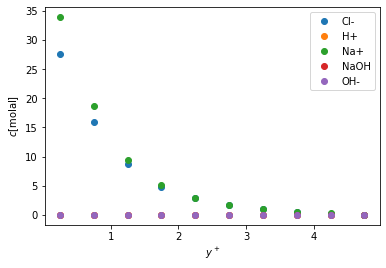

In [127]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], 'o', label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

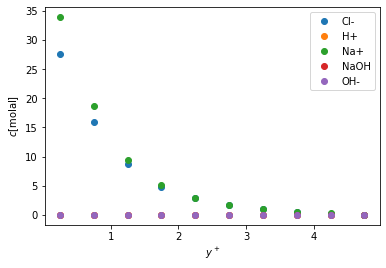

In [128]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], 'o', label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

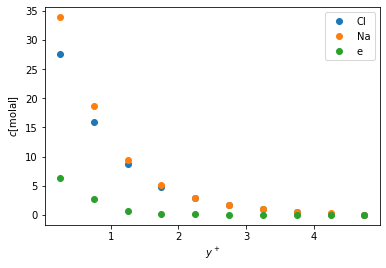

In [129]:
cel = builder.reduced_formula_matrix@c
plt.figure()
for i, el in enumerate(eqsys.solute_elements + ['e']):
    plt.plot(builder.ygrid, cel[i, :], 'o', label=el)
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

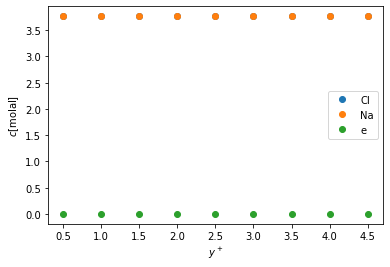

In [130]:
fluxes = builder.fluxes().detach().numpy()
yplot = builder.ypoints[1:-1].detach().numpy()
plt.figure()
for i, el in enumerate(eqsys.solute_elements + ['e']):
    plt.plot(yplot, fluxes[i, :], 'o', label=el)
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

In [131]:
4/(1e-2)*builder.fluxes()

tensor([[ 1.5071e+03,  1.5071e+03,  1.5071e+03,  1.5071e+03,  1.5071e+03,
          1.5071e+03,  1.5071e+03,  1.5071e+03,  1.5071e+03],
        [ 1.5071e+03,  1.5071e+03,  1.5071e+03,  1.5071e+03,  1.5071e+03,
          1.5071e+03,  1.5071e+03,  1.5071e+03,  1.5071e+03],
        [ 7.0855e-05,  5.4403e-04,  5.0729e-04,  7.7280e-05, -6.1702e-05,
          8.7918e-05, -6.2511e-05,  7.7725e-05,  7.5826e-05]])